# Explicabilité des Modèles CNN pour la Détection de Tumeurs Cérébrales 🧠

## 🏥 Introduction

La détection de tumeurs cérébrales à partir d'images IRM est un problème critique en imagerie médicale. Les **réseaux de neurones convolutifs (CNN)**, grâce à leur capacité à extraire des caractéristiques complexes des images, ont prouvé leur efficacité dans ce domaine. Cependant, leur nature de "boîte noire" 🕵️‍♂️ rend souvent difficile l'interprétation de leurs décisions, un aspect essentiel en médecine où la compréhension des résultats est cruciale pour la confiance des praticiens.

## 🎯 Objectif

Ce notebook explore les **méthodes d'explicabilité** pour analyser et interpréter les décisions d'un modèle CNN appliqué à des images IRM de cerveaux, classées en fonction de la présence ou de l'absence de tumeurs. Nous utiliserons des outils d'interprétabilité pour répondre à des questions comme :
- **Quelles parties de l'image influencent le plus les prédictions du modèle ?** 
- **Le modèle est-il biaisé par certaines zones non pertinentes ?** 

## 🛠️ Méthodes Utilisées

Nous utiliserons la bibliothèque **[Xplique](https://github.com/deel-ai/xplique)**, qui propose une suite d'outils spécialisés pour expliquer les modèles d'apprentissage profond, en particulier les CNN. Cette bibliothèque, open-source et facile à intégrer, permet d'appliquer plusieurs techniques d'interprétabilité. Voici les méthodes utilisées dans ce projet :
- **Guided Backpropagation** : Permet d'obtenir des visualisations en rétro-propageant uniquement les gradients positifs jusqu'à l'entrée. 
- **Integrated Gradients** : Attribue un score d'importance à chaque pixel en intégrant les gradients sur un chemin entre une référence neutre et l'image d'entrée. 
- **SmoothGrad** : Réduit le bruit des explications basées sur les gradients en moyennant plusieurs versions perturbées de l'image. 
- **Grad-CAM** : Génère des cartes de chaleur en utilisant les gradients des couches finales pour identifier les zones importantes.
- **LIME (Local Interpretable Model-agnostic Explanations)** : Approche basée sur des perturbations locales pour expliquer la prédiction d'un modèle de manière interprétable. 
- **Kernel SHAP** : Une méthode d'attribution basée sur la théorie des valeurs de Shapley pour expliquer l'impact de chaque pixel ou caractéristique. ⚖️

### Xplique en action 🛠️

Voici un aperçu visuel des explications générées par **Xplique** (source : [GitHub Xplique](https://github.com/deel-ai/xplique)) :
- [Carte de chaleur Grad-CAM 🔥](https://raw.githubusercontent.com/deel-ai/xplique/main/docs/images/grad_cam.png)
- [Attribution par Integrated Gradients 📈](https://raw.githubusercontent.com/deel-ai/xplique/main/docs/images/integrated_gradients.png)

Ces liens vous permettent de visualiser comment Xplique aide à identifier les zones les plus influentes dans les prédictions d'un modèle.

## 🗂️ Organisation

1. **Chargement et évaluation du modèle CNN** : Nous commencerons par charger le modèle pré-entraîné sur les données d'IRM de tumeurs cérébrales et évaluerons ses performances.
2. **Introduction aux outils d'explicabilité** : Une brève présentation des méthodes utilisées.
3. **Analyse visuelle des prédictions** :
   - Génération de cartes de chaleur mettant en évidence les zones importantes de l'image.
   - Comparaison des explications pour des prédictions correctes ✅ et incorrectes ❌.
4. **Interprétation des résultats** :
   - Discussion sur la pertinence des zones identifiées par le modèle.
   - Détection des éventuels biais ⚠️.

## 🎓 Importance Académique

Ce travail s'inscrit dans un cadre académique 🎓 et vise principalement à approfondir notre compréhension des méthodes d'explicabilité pour les modèles d'apprentissage profond, en particulier les CNN. L'objectif est d'explorer les forces et les limites de ces outils dans le contexte de la détection de tumeurs cérébrales à partir d'images IRM. 

Bien que ce projet ne soit pas destiné à une mise en production, il contribue à développer des compétences pratiques dans l'utilisation d'outils d'explicabilité et à renforcer notre capacité à analyser des modèles complexes dans des domaines critiques comme la santé. Ce travail peut également servir de base pour des recherches futures ou des applications académiques similaires.


In [1]:
from module_for_preprocessing_metrics import *
from tensorflow.keras.models import load_model
from xplique.attributions import GradCAM
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
import os
import yaml

with open('../config.yml', 'r') as file:
    config = yaml.safe_load(file)
size = config['données']['image']['size']
image_size = config["données"]["image"]["size"]
normalize = config["données"]["image"]["normalize"]
standardize = config["données"]["image"]["standardize"]
grayscale = config["données"]["image"]["grayscale"]



### 📥 Importation et Prétraitement des Données

Charger, préparer et organiser les images pour le modèle.


In [2]:
testing = os.path.join(os.path.abspath(os.path.join(os.getcwd(), "..")), "data", "Testing")

x_test, y_test = load_images_with_preprocessing(testing, size)

y_test_cat = to_categorical(y_test, 4)

In [3]:
print("📊 Affichage des caractéristiques du meilleur modèle sélectionné :")
model = load_saved_model('modele_brain_tumor_20241117_205951.h5')
model.summary()

📊 Affichage des caractéristiques du meilleur modèle sélectionné :
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      320       
                                                                 
 conv2d_1 (Conv2D)           (None, 252, 252, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 126, 126, 64)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 124, 124, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 122, 122, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 61, 61, 128)       0

Une fois les données prêtes et le modèle importé, expliquons le modèle CNN.

/Users/lilya/Downloads/M2 ISDS/Projects/Brain_tumor/venv/lib/python3.11/site-packages/xplique/attributions/lime.py:129: UserWarning: You set a number of perturbed samples per input >= 500 and batch_size is set to NoneThis mean that you will ask your model to handle more than 500 perturbed samples per input at once.This can lead to OOM issue. To avoid it you can set the batch_size argument.
  warnings.warn(


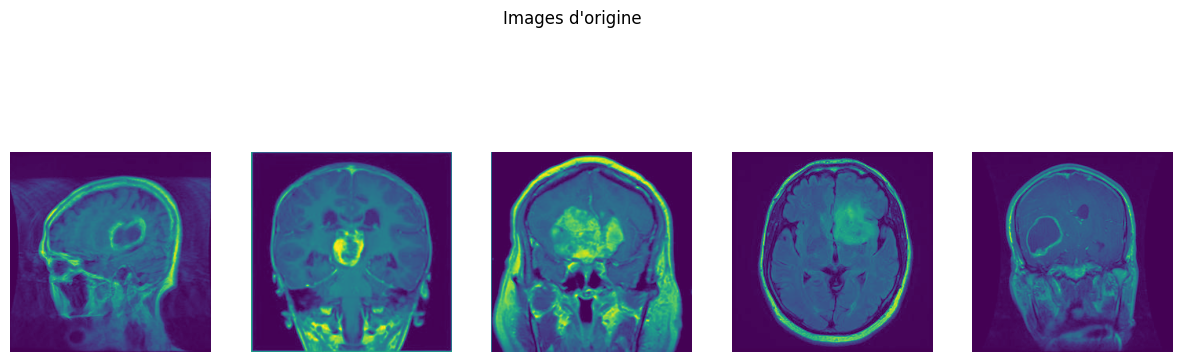

📊 Méthode : GuidedBackprop


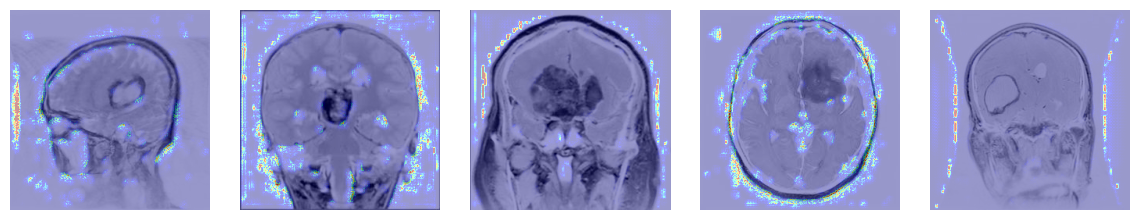



📊 Méthode : IntegratedGradients


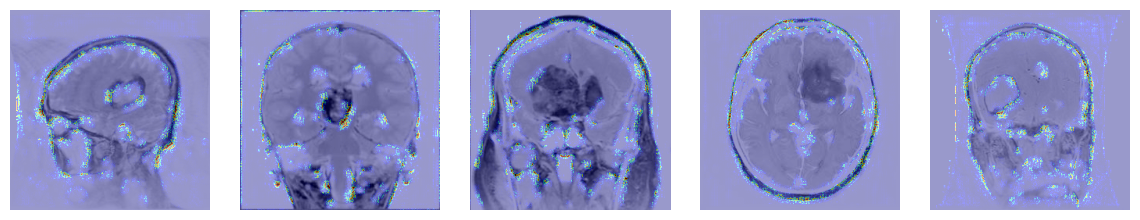



📊 Méthode : SmoothGrad


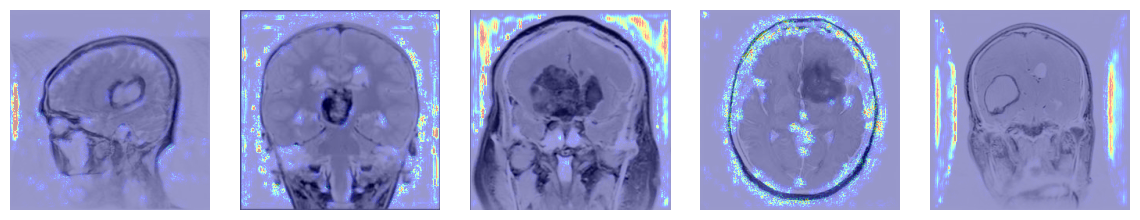



📊 Méthode : GradCAM


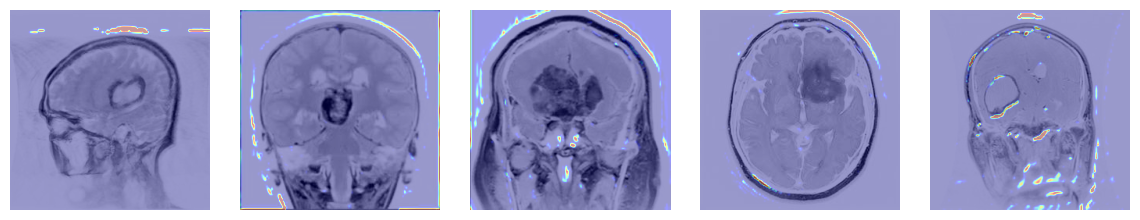



📊 Méthode : Lime


In [ ]:
import tensorflow as tf
from xplique.attributions import (
    GuidedBackprop, IntegratedGradients, SmoothGrad, GradCAM, Lime, KernelShap
)
from xplique.plots import plot_attributions
import matplotlib.pyplot as plt

# Modifier l'activation de la dernière couche pour expliquer les logits
model.layers[-1].activation = tf.keras.activations.linear

# Paramètres
batch_size = 64
X = x_test[5:10]  # Sous-échantillon des données de test
Y = y_test_cat[5:10]  # Labels correspondants

# Liste des explainers sélectionnés
explainers = [
    GuidedBackprop(model),
    IntegratedGradients(model, steps=80, batch_size=batch_size),
    SmoothGrad(model, nb_samples=80, batch_size=batch_size),
    GradCAM(model),
#    Lime(model, nb_samples=1000),
#    KernelShap(model, nb_samples=1000)
]

# Visualisation des images originales
plt.figure(figsize=(15, 5))
for i in range(len(X)):
    plt.subplot(1, len(X), i + 1)
    plt.imshow(X[i])  # Affiche l'image d'origine
    plt.axis('off')
plt.suptitle("Images d'origine")
plt.show()

# Génération et affichage des attributions pour chaque méthode
for explainer in explainers:
    print(f"📊 Méthode : {explainer.__class__.__name__}")

    # Calcul des attributions
    explanations = explainer(X, Y)

    # Affichage des attributions
    plot_attributions(
        explanations,
        X,
        img_size=2.0,
        cmap='jet',
        alpha=0.4,
        cols=len(X),
        absolute_value=True,
        clip_percentile=0.5
    )
    plt.show()
    print("\n")


# Images Bien Prédites

Voici des exemples d'images que le modèle a correctement classées.

Le modèle a utilisé des **caractéristiques clés** comme les formes ou les textures pour faire ces prédictions.


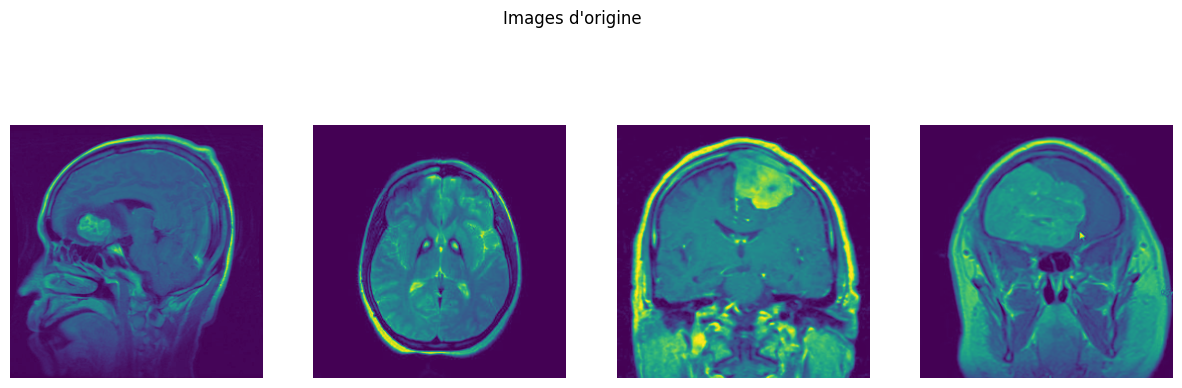

📊 Méthode : GuidedBackprop


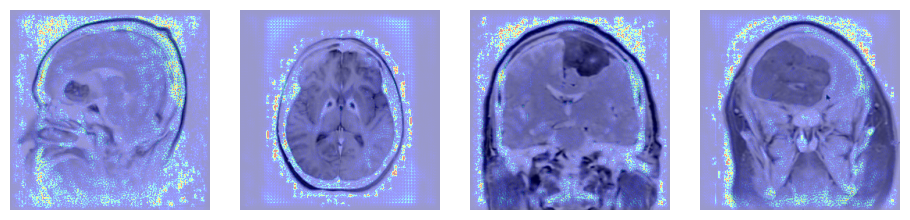



📊 Méthode : IntegratedGradients


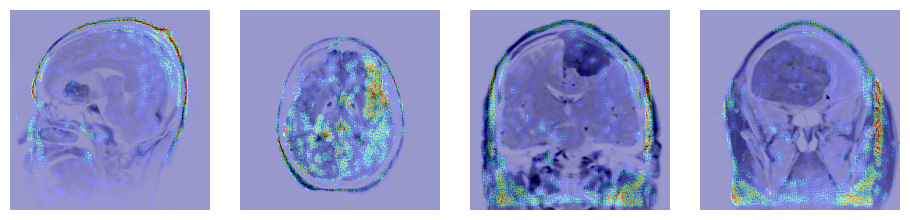



📊 Méthode : SmoothGrad


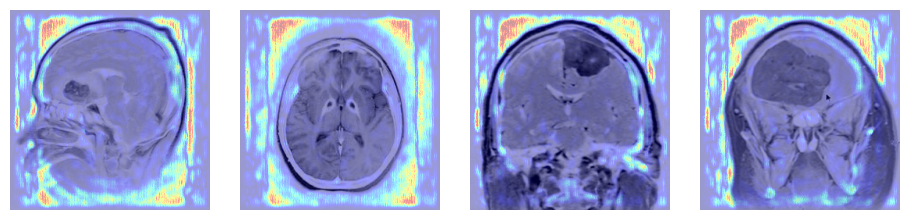



📊 Méthode : GradCAM


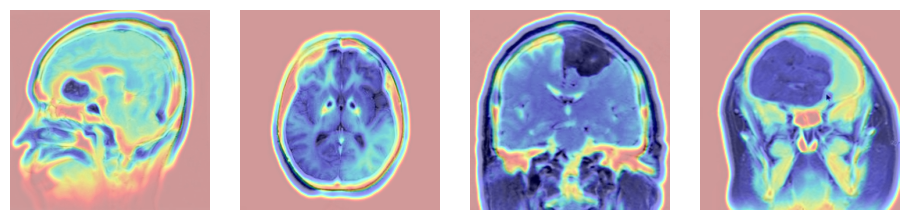

In [7]:
import tensorflow as tf
from xplique.attributions import (
    GuidedBackprop, IntegratedGradients, SmoothGrad, GradCAM, Lime, KernelShap
)
from xplique.plots import plot_attributions
import matplotlib.pyplot as plt

# Modifier l'activation de la dernière couche pour expliquer les logits
model.layers[-1].activation = tf.keras.activations.linear

# Paramètres
batch_size = 64

# Liste des explainers sélectionnés
explainers = [
    GuidedBackprop(model),
    IntegratedGradients(model, steps=80, batch_size=batch_size),
    SmoothGrad(model, nb_samples=80, batch_size=batch_size),
    GradCAM(model),
#    Lime(model, nb_samples=1000),
#    KernelShap(model, nb_samples=1000)
]

# Visualisation des images originales
plt.figure(figsize=(15, 5))
for i in range(len(X)):
    plt.subplot(1, len(X), i + 1)
    plt.imshow(X[i])  # Affiche l'image d'origine
    plt.axis('off')
plt.suptitle("Images d'origine bien prédites")
plt.show()

# Génération et affichage des attributions pour chaque méthode
for explainer in explainers:
    print(f"📊 Méthode : {explainer.__class__.__name__}")

    # Calcul des attributions
    explanations = explainer(X, Y)

    # Affichage des attributions
    plot_attributions(
        explanations,
        X,
        img_size=2.0,
        cmap='jet',
        alpha=0.4,
        cols=len(X),
        absolute_value=True,
        clip_percentile=0.5
    )
    plt.show()
    print("\n")



## Conclusion  
Le modèle utilise des zones **clés** comme les contours, les structures internes et les régions tumorales pour classer les images.  
Chaque méthode apporte une **vision différente**, confirmant la cohérence des prédictions.
